#Time series based prediction for active power between 21st Jan 2021 to 31st Jan 2021 based on data set with observations recorded in a solar plant over a year.

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#import time series libraries
#Load library for Augmented Deckey Fuller(ADF) test to test the stationarity 
#of the data; It also contains ACF and PACF tests for knowing q and p values
from statsmodels.tsa.stattools import adfuller, acf, pacf
#load arima model library
from statsmodels.tsa.arima_model import ARIMA
#to extract different time series components
from statsmodels.tsa.seasonal import seasonal_decompose
#to find whether my residuals are having white noise
import statsmodels.api as sm
import seaborn as sns

In [3]:
#load dataset and set date_time column as index
power_data = pd.read_csv("test_dataset.csv", index_col="date_time",parse_dates=True)
#For time series forcasting we must make data column as index column
#Lets check if dataset is loaded properly or not
power_data.head(10)

,RY VOLTAGE,YB VOLTAGE,BR VOLTAGE,R PHASE CURRENT,Y PHASE CURRENT,B PHASE CURRENT,PF,FREQUENCY,APPARENT POWER,ACTIVE POWER,...,HORIZONTAL RADIATION,TILT_RADIATION,DAY HORIZONTAL RADIATION,DAY TILT RADIATION,MODULE TEMPERATURE,AMBIENT TEMPERATURE,WIND SPEED,WIND DIRECTION,HUMIDITY,RAIN
date_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,68759.56641,68742.19531,68300.51563,2.1605,1.9296,2.5329,-0.204,100.098999,129.770001,-79.580002,...,0.0,0.000000,9.379745,10.732933,17.000000,20.500000,1.5,84.199997,85.699997,0.0
2020-01-01 00:10:00,68302.45703,68265.07031,67853.40625,2.1000,1.8774,2.4804,-0.044,99.993000,125.780003,-77.770001,...,0.0,0.000000,9.379745,10.732933,17.200001,20.600000,0.7,76.099998,86.000000,0.0
2020-01-01 00:20:00,68210.21484,68185.65234,67773.36328,2.0753,1.8809,2.4350,-0.024,99.968998,124.340000,-76.830002,...,0.0,0.000000,0.000000,0.000000,17.200001,20.700001,0.9,92.800003,86.000000,0.0
2020-01-01 00:30:00,68324.65234,68296.44141,67882.87891,2.0419,1.8650,2.4225,-0.021,100.057003,123.510002,-76.010002,...,0.0,0.000000,0.000000,0.000000,16.900000,20.500000,0.7,68.000000,86.400002,0.0
2020-01-01 00:40:00,68393.61719,68388.14453,67939.93750,2.0887,1.9138,2.4445,-0.059,100.033001,125.800003,-76.989998,...,0.0,0.000000,0.000000,0.000000,16.700001,20.400000,0.7,92.400002,87.199997,0.0
2020-01-01 00:50:00,68468.92969,68459.64063,68018.52734,2.0983,1.9021,2.4697,-0.086,100.026001,126.440002,-77.150002,...,0.0,0.000000,0.000000,0.000000,16.900000,20.200001,0.8,102.000000,87.400002,0.0
2020-01-01 01:00:00,68579.20703,68560.01563,68128.00000,2.0828,1.9222,2.4385,-0.068,100.207001,126.090004,-76.990002,...,0.0,0.000000,0.000000,0.000000,16.900000,20.299999,1.0,91.800003,87.400002,0.0
2020-01-01 01:10:00,68445.83984,68394.59766,67993.28906,2.0695,1.8554,2.4399,-0.067,100.046997,124.309997,-76.980000,...,0.0,0.000000,0.000000,0.000000,16.799999,20.000000,0.7,128.899994,88.099998,0.0
2020-01-01 01:20:00,68522.01563,68493.76953,68067.86719,2.0859,1.8754,2.4597,-0.098,100.042999,125.459999,-76.590000,...,2.4,2.133333,0.000000,0.000000,17.700001,20.100000,0.8,111.699997,88.500000,0.0


We can see that the data is well sorted on time. So we don't need to sort the data.

In [4]:
#Lets describe our data statistical point of view
power_data.describe()

,RY VOLTAGE,YB VOLTAGE,BR VOLTAGE,R PHASE CURRENT,Y PHASE CURRENT,B PHASE CURRENT,PF,FREQUENCY,APPARENT POWER,ACTIVE POWER,...,HORIZONTAL RADIATION,TILT_RADIATION,DAY HORIZONTAL RADIATION,DAY TILT RADIATION,MODULE TEMPERATURE,AMBIENT TEMPERATURE,WIND SPEED,WIND DIRECTION,HUMIDITY,RAIN
count,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,...,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000,61070.000000
mean,68520.677738,68417.572541,68006.362330,231.341406,230.821334,230.932071,-0.487763,99.552633,13502.623738,13359.112601,...,215.985609,229.842972,2.607516,2.769352,28.417017,25.802995,2.387162,175.196347,66.902132,0.000164
std,4687.411699,4706.444548,4645.515323,312.230323,312.207537,311.959227,1.227029,6.579384,18180.995182,18250.080619,...,314.511718,328.434546,2.529983,2.693212,11.260193,4.879702,13.332223,93.015805,21.739088,0.006573
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.999000,0.000000,0.000000,-222.029999,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67882.188477,67697.270505,67396.717770,2.723800,2.198900,2.908950,-1.996000,99.938004,154.539997,-82.480003,...,0.000000,0.000000,0.000000,0.000000,20.600000,22.700001,1.200000,79.900002,51.900002,0.000000
50%,68931.015630,68859.798830,68418.888675,5.697100,4.691400,5.213250,-0.220500,100.021000,317.904999,0.000000,...,4.533333,4.480000,2.142360,2.257321,24.299999,25.500000,2.100000,202.399994,69.000000,0.000000
75%,69933.377933,69888.447267,69414.827150,455.673646,454.985140,454.717594,0.528000,100.083000,26720.405517,26713.572755,...,362.306679,397.226654,5.056238,5.268755,36.299999,29.200001,3.200000,256.399994,85.699997,0.000000
max,72238.816410,72266.535160,71658.269530,892.824982,892.709992,892.590393,2.000000,100.654003,52949.718750,52852.369140,...,1413.493408,1437.440063,13.493360,14.782917,64.099998,39.500000,3276.699951,3276.699951,100.000000,0.600000


In [5]:
#Get colmn names
power_data.columns

Index(['RY VOLTAGE', 'YB VOLTAGE', 'BR VOLTAGE', 'R PHASE CURRENT',
       'Y PHASE CURRENT', 'B PHASE CURRENT', 'PF', ' FREQUENCY',
       'APPARENT POWER', 'ACTIVE POWER', 'REACTIVE POWER', 'TODAY EXPORT',
       'TODAY IMPORT', 'TOTAL EXPORT', 'TOTAL IMPORT', 'HORIZONTAL RADIATION',
       'TILT_RADIATION', 'DAY HORIZONTAL RADIATION', 'DAY TILT RADIATION',
       'MODULE TEMPERATURE', 'AMBIENT TEMPERATURE', 'WIND SPEED',
       'WIND DIRECTION', 'HUMIDITY', 'RAIN'],
      dtype='object')

In [7]:
#Check for current indices if they are date wise or not
power_data.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:10:00',
               '2020-01-01 00:20:00', '2020-01-01 00:30:00',
               '2020-01-01 00:40:00', '2020-01-01 00:50:00',
               '2020-01-01 01:00:00', '2020-01-01 01:10:00',
               '2020-01-01 01:20:00', '2020-01-01 01:30:00',
               ...
               '2021-01-20 22:20:00', '2021-01-20 22:30:00',
               '2021-01-20 22:40:00', '2021-01-20 22:50:00',
               '2021-01-20 23:00:00', '2021-01-20 23:10:00',
               '2021-01-20 23:20:00', '2021-01-20 23:30:00',
               '2021-01-20 23:40:00', '2021-01-20 23:50:00'],
              dtype='datetime64[ns]', name='date_time', length=61071, freq=None)

## Data Exploration and Preparation ##
As we need to predict 'ACTIVE POWER' data based on the current available data. 
Some of the columns are irrelevant for our study. So make a new dataframe with only relevant columns. 
Relevant columns based on primary observation are: 
'HORIZONTAL RADIATION','TILT_RADIATION', 'DAY HORIZONTAL RADIATION', 'DAY TILT RADIATION','MODULE TEMPERATURE', 'AMBIENT TEMPERATURE', 'WIND SPEED','WIND DIRECTION', 'HUMIDITY', 'RAIN'
Above columns seems relevant as they might have significant impact on 'ACTIVE POWER' generation. 

In [8]:
p_data = pd.DataFrame(data=power_data,columns=['ACTIVE POWER','HORIZONTAL RADIATION',
       'TILT_RADIATION', 'DAY HORIZONTAL RADIATION', 'DAY TILT RADIATION',
       'MODULE TEMPERATURE', 'AMBIENT TEMPERATURE', 'WIND SPEED',
       'WIND DIRECTION', 'HUMIDITY', 'RAIN'])
#Lets check whats there in data
p_data.head(10)

,ACTIVE POWER,HORIZONTAL RADIATION,TILT_RADIATION,DAY HORIZONTAL RADIATION,DAY TILT RADIATION,MODULE TEMPERATURE,AMBIENT TEMPERATURE,WIND SPEED,WIND DIRECTION,HUMIDITY,RAIN
date_time,,,,,,,,,,,
2020-01-01 00:00:00,-79.580002,0.0,0.000000,9.379745,10.732933,17.000000,20.500000,1.5,84.199997,85.699997,0.0
2020-01-01 00:10:00,-77.770001,0.0,0.000000,9.379745,10.732933,17.200001,20.600000,0.7,76.099998,86.000000,0.0
2020-01-01 00:20:00,-76.830002,0.0,0.000000,0.000000,0.000000,17.200001,20.700001,0.9,92.800003,86.000000,0.0
2020-01-01 00:30:00,-76.010002,0.0,0.000000,0.000000,0.000000,16.900000,20.500000,0.7,68.000000,86.400002,0.0
2020-01-01 00:40:00,-76.989998,0.0,0.000000,0.000000,0.000000,16.700001,20.400000,0.7,92.400002,87.199997,0.0
2020-01-01 00:50:00,-77.150002,0.0,0.000000,0.000000,0.000000,16.900000,20.200001,0.8,102.000000,87.400002,0.0
2020-01-01 01:00:00,-76.990002,0.0,0.000000,0.000000,0.000000,16.900000,20.299999,1.0,91.800003,87.400002,0.0
2020-01-01 01:10:00,-76.980000,0.0,0.000000,0.000000,0.000000,16.799999,20.000000,0.7,128.899994,88.099998,0.0
2020-01-01 01:20:00,-76.590000,2.4,2.133333,0.000000,0.000000,17.700001,20.100000,0.8,111.699997,88.500000,0.0


If we observe closely the data values are -ve between night time i.e. from 6 p.m. to  7 a.m., which we neednot consider while training our model as it might bring skewness to our model
So remove the timestamps '18:00:00' evening to '06:50:00' morning and rearrange  the data

In [9]:
#First make all negative 'ACTIVE POWER' entries to 0 
p_data['ACTIVE POWER'] = p_data['ACTIVE POWER'].apply(lambda x: 0 if x < 0 else x) 
p_data.head(45)

,ACTIVE POWER,HORIZONTAL RADIATION,TILT_RADIATION,DAY HORIZONTAL RADIATION,DAY TILT RADIATION,MODULE TEMPERATURE,AMBIENT TEMPERATURE,WIND SPEED,WIND DIRECTION,HUMIDITY,RAIN
date_time,,,,,,,,,,,
2020-01-01 00:00:00,0.000000,0.000000,0.000000,9.379745,10.732933,17.000000,20.500000,1.5,84.199997,85.699997,0.0
2020-01-01 00:10:00,0.000000,0.000000,0.000000,9.379745,10.732933,17.200001,20.600000,0.7,76.099998,86.000000,0.0
2020-01-01 00:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,17.200001,20.700001,0.9,92.800003,86.000000,0.0
2020-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,16.900000,20.500000,0.7,68.000000,86.400002,0.0
2020-01-01 00:40:00,0.000000,0.000000,0.000000,0.000000,0.000000,16.700001,20.400000,0.7,92.400002,87.199997,0.0
2020-01-01 00:50:00,0.000000,0.000000,0.000000,0.000000,0.000000,16.900000,20.200001,0.8,102.000000,87.400002,0.0
2020-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,16.900000,20.299999,1.0,91.800003,87.400002,0.0
2020-01-01 01:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,16.799999,20.000000,0.7,128.899994,88.099998,0.0
2020-01-01 01:20:00,0.000000,2.400000,2.133333,0.000000,0.000000,17.700001,20.100000,0.8,111.699997,88.500000,0.0


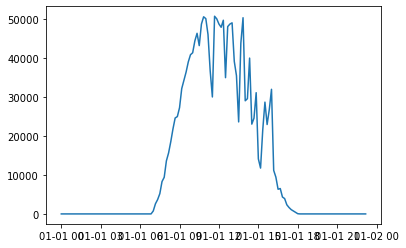

In [10]:
#Plot 'ACTIVE POWER' data for a day
plt.plot(p_data['ACTIVE POWER'][0:140])

In [11]:
#remove null entries from 'ACTIVE POWER' column
new_data = p_data[p_data['ACTIVE POWER']>0]

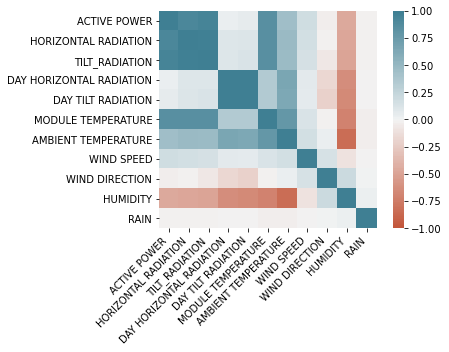

In [12]:
corr = new_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Using heatmap it is quite obvious that there is dependency of ACTIVE POWER on number of external factors like 'HORIZONTAL RADIATION','TILT_RADIATION', 'DAY HORIZONTAL RADIATION', 'DAY TILT RADIATION','MODULE TEMPERATURE', 'AMBIENT TEMPERATURE', 'WIND SPEED','WIND DIRECTION', 'HUMIDITY', 'RAIN'.
ARIMA model might fail to catch this dependency as its prediction is fully dependent auto correlation among its own observations. Let us see how the ARIMA model behaves with the data.

In [13]:
new_data = new_data[['ACTIVE POWER']]
new_data

,ACTIVE POWER
date_time,
2020-01-01 07:00:00,755.999988
2020-01-01 07:10:00,2600.150025
2020-01-01 07:20:00,3686.950074
2020-01-01 07:30:00,5202.679932
2020-01-01 07:40:00,8302.890137
...,...
2021-01-20 17:30:00,6623.739990
2021-01-20 17:40:00,4344.169922
2021-01-20 17:50:00,2428.310059


In [14]:
#check the stationarity in the data using Augmented Decky Fuller Test
def checkStationarity(d):
    pvalue = adfuller(d)[1]
    if pvalue<0.05: #asuming 0.95 level of confidence
        msg = "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)
    return(msg)

#Check stationarity of 'ACTIVE POWER' data column
print(checkStationarity(new_data))

pvalue=2.0468853805727342e-28. Data is Stationary. Proceed to model building


Text(0.5, 1.0, 'Active Power over entire interval')

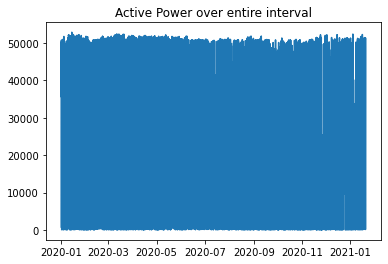

In [15]:
#plot the data 
plt.plot(new_data)
plt.title("Active Power over entire interval")

The data seems stationary as it can be observed from above plot and through pvalue check. Hence we can go for model building. We will select ARIMA model for time series forecasting.

In [18]:
# determine p,q values using the ACF and PACF charts
# PACF -> p component of ARIMA (AR(p) model)
# ACF ->  q component of ARIMA (MA(q) model)
lags = 40
lag_acf = acf(new_data,nlags=lags)
lag_pacf = pacf(new_data,nlags=lags,method='ols')

Text(0.5, 1.0, 'Auto Correlation [ACF]')

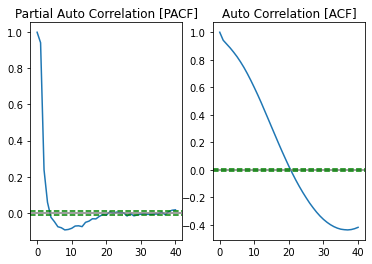

In [19]:
# plot the correlogram to determine the optimum p (Partial Auto Correlation) and q (Auto Correlation) values 
#for Confidence level at 95% we have z score = +- 1.645
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.645/np.sqrt(len(new_data)),linestyle='--',color='green')
plt.axhline(y=1.645/np.sqrt(len(new_data)),linestyle='--',color='green')
plt.title('Partial Auto Correlation [PACF]')

plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='-',color='gray')
plt.axhline(y=-1.645/np.sqrt(len(new_data)),linestyle='--',color='green')
plt.axhline(y=1.645/np.sqrt(len(new_data)),linestyle='--',color='green')
plt.title('Auto Correlation [ACF]')

Select non-zero values at first p points; zero values elsewhere for	AR(p) Model
Select non-zero values at first q points; zero values elsewhere for	MA(q) Model
Ideally try different combinations of p& q

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will

                              ARMA Model Results                              
Dep. Variable:           ACTIVE POWER   No. Observations:                30436
Model:                     ARMA(1, 1)   Log Likelihood             -306252.064
Method:                       css-mle   S.D. of innovations           5671.387
Date:                Mon, 02 Aug 2021   AIC                         612512.128
Time:                        00:46:55   BIC                         612545.421
Sample:                             0   HQIC                        612522.803
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.689e+04    787.779     34.129      0.000    2.53e+04    2.84e+04
ar.L1.ACTIVE POWER     0.9692      0.001    655.511      0.000       0.966       0.972
ma.L1.ACTIVE POWER  

Text(0.5, 1.0, 'Model1 Residuals Distribution')

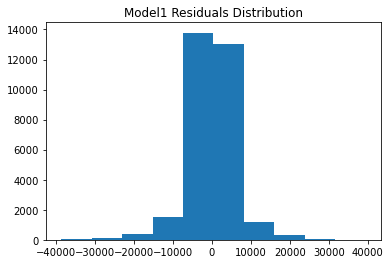

In [20]:
# to get the best model, try different combinations of p and q
# the best model is the one that has the least AIC / BIC scores

#  Model : #1
p=1; d=0; q=1

# build the ARIMA model
m1 = ARIMA(new_data,order=(p,d,q)).fit()
print(m1.summary())
plt.hist(m1.resid)
plt.title('Model1 Residuals Distribution')

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will

                              ARMA Model Results                              
Dep. Variable:           ACTIVE POWER   No. Observations:                30436
Model:                     ARMA(3, 2)   Log Likelihood             -305276.507
Method:                       css-mle   S.D. of innovations           5492.429
Date:                Mon, 02 Aug 2021   AIC                         610567.014
Time:                        00:47:22   BIC                         610625.277
Sample:                             0   HQIC                        610585.696
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.689e+04    291.847     92.125      0.000    2.63e+04    2.75e+04
ar.L1.ACTIVE POWER     2.2122      0.014    154.233      0.000       2.184       2.240
ar.L2.ACTIVE POWER  

Text(0.5, 1.0, 'Model2 Residuals Distribution')

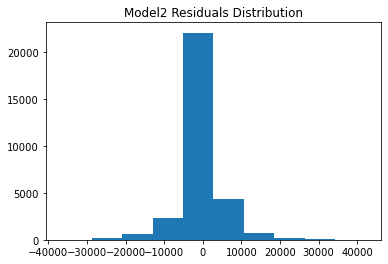

In [21]:
#  Model : #2
p=3; d=0; q=2

# build the ARIMA model
m2 = ARIMA(new_data,order=(p,d,q)).fit()
print(m2.summary())
plt.hist(m2.resid)
plt.title('Model2 Residuals Distribution')

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will

                              ARMA Model Results                              
Dep. Variable:           ACTIVE POWER   No. Observations:                30436
Model:                     ARMA(2, 2)   Log Likelihood             -305414.334
Method:                       css-mle   S.D. of innovations           5517.368
Date:                Mon, 02 Aug 2021   AIC                         610840.667
Time:                        00:47:50   BIC                         610890.608
Sample:                             0   HQIC                        610856.680
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.689e+04    286.048     93.993      0.000    2.63e+04    2.74e+04
ar.L1.ACTIVE POWER     1.9503      0.002    886.216      0.000       1.946       1.955
ar.L2.ACTIVE POWER  

Text(0.5, 1.0, 'Model3 Residuals Distribution')

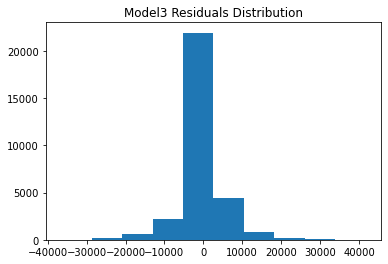

In [22]:
#  Model : #3
p=2; d=0; q=2

# build the ARIMA model
m3 = ARIMA(new_data['ACTIVE POWER'],order=(p,d,q)).fit()
print(m3.summary())
plt.hist(m3.resid)
plt.title('Model3 Residuals Distribution')

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will

                              ARMA Model Results                              
Dep. Variable:           ACTIVE POWER   No. Observations:                30436
Model:                     ARMA(3, 1)   Log Likelihood             -305840.182
Method:                       css-mle   S.D. of innovations           5595.131
Date:                Mon, 02 Aug 2021   AIC                         611692.364
Time:                        00:48:22   BIC                         611742.304
Sample:                             0   HQIC                        611708.377
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.689e+04    307.698     87.379      0.000    2.63e+04    2.75e+04
ar.L1.ACTIVE POWER     1.6386      0.006    274.366      0.000       1.627       1.650
ar.L2.ACTIVE POWER  

Text(0.5, 1.0, 'Model4 Residuals Distribution')

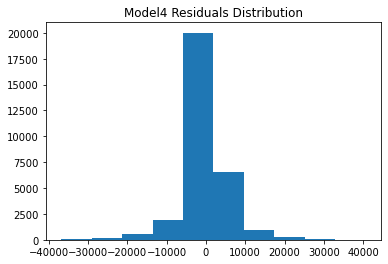

In [23]:
#  Model : #4
p=3; d=0; q=1

# build the ARIMA model
m4 = ARIMA(new_data,order=(p,d,q)).fit()
print(m4.summary())
plt.hist(m4.resid)
plt.title('Model4 Residuals Distribution')

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will

                              ARMA Model Results                              
Dep. Variable:           ACTIVE POWER   No. Observations:                30436
Model:                    ARMA(10, 2)   Log Likelihood             -305251.843
Method:                       css-mle   S.D. of innovations           5487.979
Date:                Mon, 02 Aug 2021   AIC                         610531.686
Time:                        00:49:27   BIC                         610648.214
Sample:                             0   HQIC                        610569.050
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.689e+04    299.774     89.689      0.000    2.63e+04    2.75e+04
ar.L1.ACTIVE POWER      2.1447      0.064     33.438      0.000       2.019       2.270
ar.L2.ACTIVE POW

Text(0.5, 1.0, 'Model5 Residuals Distribution')

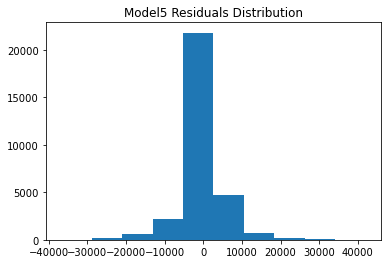

In [24]:
#  Model : #5
p=10; d=0; q=2

# build the ARIMA model
m5 = ARIMA(new_data,order=(p,d,q)).fit()
print(m5.summary())
plt.hist(m5.resid)
plt.title('Model5 Residuals Distribution')

#  Model 1
    p=1; d=0; q=1
    AIC                         612512.128
    BIC                         612545.421
    
# Model 2
    p=3; d=0; q=2
    AIC                         610567.014
    BIC                         610625.277

# Model 3
    p=2; d=0; q=2
    AIC                         610840.667
    BIC                         610890.608
    
    
# Model 4
    p=3; d=0; q=1
    AIC                         611692.364
    BIC                         611742.304
    
# Model 5
    p=10; d=0; q=2
    AIC                         610531.686
    BIC                         610648.214
    
Out of all five model results, model 2 and model 5 have the least AIC and BIC scores. So we can go with any one model. As model 2 finds very first peak at p=3 we will go with this model2 with (p=3, d=0, q=2).    

In [25]:
# check model goodness using LJung-Box test

pvalue = sm.stats.acorr_ljungbox(m2.resid, lags=[1])[1]

if pvalue < 0.05:
    print('Reject H0: Bad model')
else:
    print('FTR H0: Good model')

FTR H0: Good model


D:\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


So ljungbox test tells us that our hypothesis is correct and we accept H0 

In [26]:
# forecast for the next 'n' steps
preds = m2.forecast(steps=737)
print("Predictions",preds)

# forecasts for the 737 steps
f = preds[0]
print("Forecasts",f)
len(f)


Predictions (array([ -212.24513778,  -730.43021489, -1087.60704441, -1242.0764982 ,
       -1189.03840738,  -934.1662104 ,  -486.655738  ,   142.66930072,
         941.93981214,  1898.48387583,  2998.98119574,  4229.59419013,
        5576.09189461,  7023.97026924,  8558.56926832, 10165.18623248,
       11829.18499649, 13536.10010805, 15271.73559818, 17022.25780274,
       18774.28179723, 20514.95107108, 22232.01013185, 23913.8697942 ,
       25549.66497135, 27129.30484923, 28643.5153838 , 30083.87412045,
       31442.8373907 , 32713.75999465, 33890.90752823, 34969.46156168,
       35945.51791951, 36816.07835243, 37579.03592842, 38233.15450274,
       38778.04265539, 39214.12250938, 39542.59386377, 39765.39409232,
       39885.15427112, 39905.15200783, 39829.2614497 , 39661.90094937,
       39407.97886497, 39072.83796554, 38662.19890411, 38182.10320877,
       37638.85622749, 37038.97044539, 36389.10957334, 35696.03378515,
       34966.54645706, 34207.44273804, 33425.46025259, 32627.232

737

Text(0.5, 1.0, 'Predictions for 1/21/2021 sunrise to sunset ')

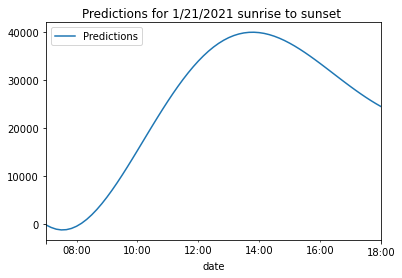

In [34]:
#Create a prediction dataframe for visualizations
#For
n = 67
st = 0; ed = n
df = pd.DataFrame(columns=['date','Predictions'])
timestmp = "1/21/2021 07:00"
etimstp = "1/21/2021 18:00"
df['date'] =  pd.date_range(start= timestmp, end= etimstp, freq="10Min")
df['Predictions'] = f[st:ed]
df = df.set_index('date')
df   
#visualizations
df.plot()
plt.title("Predictions for 1/21/2021 sunrise to sunset ")

